# Import Library

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.optim as optims

from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.functional import InterpolationMode

import pandas as pd
import seaborn as sns
from collections import defaultdict
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from torch.utils.data import SequentialSampler

!pip install torchmetrics
!pip install --upgrade torchmetrics
import torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 14.7 MB/s eta 0:00:00


In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda') # GPU
else:
  device = torch.device('cpu') # CPU

print(device)
gpu_count = torch.cuda.device_count()

print("Using", gpu_count, "GPUs")
print("CUDA is available:", torch.cuda.is_available())

cpu
Using 0 GPUs
CUDA is available: False


In [ ]:
# train loop
def train_one_epoch(model, device, criterion, optimizer, train_data_loader):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    t_Labels = []
    t_Preds = []

    model.train()

    for batch_idx, (images, labels) in enumerate (train_data_loader):
        images = images.to(device)
        labels = labels.to(device).float()
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels.unsqueeze(1))

        # Calculating Loss
        epoch_loss.append(loss.item())

        # Calculating Metrics
        predicts = (preds > 0.5).float()
        predicts = predicts.view(-1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)

        epoch_acc.append(acc)

        t_Labels.extend(labels)
        t_Preds.extend(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100

    return epoch_loss, epoch_acc, total_time, t_Preds, t_Labels

# validation loop
def val_one_epoch(model, device, criterion, val_data_loader, best_acc, save):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    v_Labels = []
    v_Preds = []

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device).float()
            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels.unsqueeze(1))
            epoch_loss.append(loss.item())

            # Calculating Metrics
            predicts = (preds > 0.5).float()
            predicts = predicts.view(-1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

            v_Labels.extend(labels)
            v_Preds.extend(predicts)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100

    # Saving best model
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), f"/content/drive/MyDrive/HW3_dataset/HW3_model.pth")

    return epoch_loss, epoch_acc, total_time, best_acc, v_Preds, v_Labels

# evaluate loop (test loop)
def evaluate(model, device, model_path, test_loader):
    try:
        state_dict = torch.load(model_path, weights_only=True) # Prevent risks with untrusted pickle data.
        model.load_state_dict(state_dict)
        #model.load_state_dict(torch.load(model_path)) # TA's code
        print("Model weights loaded successfully.")
    except Exception as e:
        print("Warning: Failed to load model weights. Using randomly initialized weights instead.")
        print(e)

    model.to(device)
    model.eval()

    test_loss = []
    test_acc = []

    e_Labels = []
    e_Preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float()

            # Forward pass
            preds = model(images)

            # Calculating loss
            loss = criterion(preds, labels.unsqueeze(1))
            test_loss.append(loss.item())

            # Calculating accuracy
            predicts = (preds > 0.5).float()
            predicts = predicts.view(-1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            test_acc.append(acc)

            e_Labels.extend(labels)
            e_Preds.extend(predicts)

    # Overall test results
    avg_test_loss = np.mean(test_loss)
    avg_test_acc = np.mean(test_acc) * 100

    print(f"Test Accuracy: {avg_test_acc:.2f}%")
    print(f"Test Loss: {avg_test_loss:.4f}")

    return avg_test_loss, avg_test_acc, e_Preds, e_Labels

# Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# define folder path for each set
train_path = '/content/drive/MyDrive/HW3_dataset/train'
test_path = '/content/drive/MyDrive/HW3_dataset/test_balance'
val_path = '/content/drive/MyDrive/HW3_dataset/val_balance'

# define transformation
train_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=1),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)), # Add blur
    transforms.RandomRotation(degrees=10), # Add random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Add color jitter
    transforms.ToTensor(),
])

common_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# create datasets
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_path, transform=common_transform)
val_dataset = datasets.ImageFolder(val_path, transform=common_transform)

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # TA's code shuffle=True
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model

In [ ]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(256 * 256 * 1, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.2), # TA deafult with dropout p=0.5

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.2), # TA default with dropout p=0.5

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.2), # TA default with dropout p=0.5

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.2), # TA default with dropout p=0.5

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.2), # TA default with dropout p=0.5

    nn.Linear(64, 1),
    nn.Sigmoid()
)

model.to(device)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.2, inplace=False)
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=64, out_features=64, bias=True)
  (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.2, inplace=False)
  (13): Linear(in_features=64, out_features=64, bias=True)
  (14): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): ReLU()
  (16): Dropout(p=0.2, inplace=False)
  (17): Linear(in_features=64, out_features=64, bias=True)
  (18): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (19):

# Loop

In [ ]:
# define the weight_init function and make sure the same weights every time
def weight_init(m):
    if isinstance(m, nn.Linear):
        torch.manual_seed(42)  # Set the seed for CPU
        if torch.cuda.is_available():
            torch.cuda.manual_seed(42)  # Set the seed for CUDA
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [ ]:
# hyperparameter
lr = 0.0001 # TA set default lr to 0.001
weight_decay = 0.0001 # TA set default weight_decay to 0.001
optimizer = optims.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
lr_scheduler = optims.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, mode='max') # TA set default patience=5
epochs = 30 # TA set default epochs to 10
criterion = nn.BCELoss() # TA set default criterion to nn.BCELoss()

# save checkpoint
save = 'model'

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_acc = 0.0
output_list = []

# Initial weight with your_seed to keep the same random weights for each initialization
model.apply(weight_init)

for epoch in range(epochs):
    train_loss, train_acc, train_time, train_p, train_l = train_one_epoch(model, device, criterion, optimizer, train_loader)
    val_loss, val_acc, val_time, best_acc, val_p, val_l = val_one_epoch(model, device, criterion, val_loader, best_acc, save)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    total_time = train_time + val_time
    output_str = f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - train_acc: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_acc: {val_acc:.2f}% - time: {total_time:.2f}s"
    output_list.append(output_str)
    print(output_str)
    lr_scheduler.step(val_acc)

Epoch 1/30 - loss: 0.6661 - train_acc: 60.40% - val_loss: 0.7385 - val_acc: 56.25% - time: 118.49s
Epoch 2/30 - loss: 0.5921 - train_acc: 68.55% - val_loss: 0.5681 - val_acc: 74.31% - time: 104.33s
Epoch 3/30 - loss: 0.5025 - train_acc: 76.22% - val_loss: 0.5529 - val_acc: 70.54% - time: 103.36s
Epoch 4/30 - loss: 0.4520 - train_acc: 81.15% - val_loss: 0.5612 - val_acc: 66.83% - time: 104.32s
Epoch 5/30 - loss: 0.4098 - train_acc: 83.64% - val_loss: 0.4544 - val_acc: 79.48% - time: 103.88s
Epoch 6/30 - loss: 0.3618 - train_acc: 87.21% - val_loss: 0.4438 - val_acc: 80.23% - time: 103.64s
Epoch 7/30 - loss: 0.3263 - train_acc: 89.01% - val_loss: 0.4492 - val_acc: 78.69% - time: 104.27s
Epoch 8/30 - loss: 0.3033 - train_acc: 91.11% - val_loss: 0.4733 - val_acc: 76.73% - time: 102.08s
Epoch 9/30 - loss: 0.2715 - train_acc: 91.11% - val_loss: 0.5199 - val_acc: 71.50% - time: 102.73s
Epoch 10/30 - loss: 0.2560 - train_acc: 91.89% - val_loss: 0.4103 - val_acc: 83.65% - time: 102.49s
Epoch 11/

# Graph

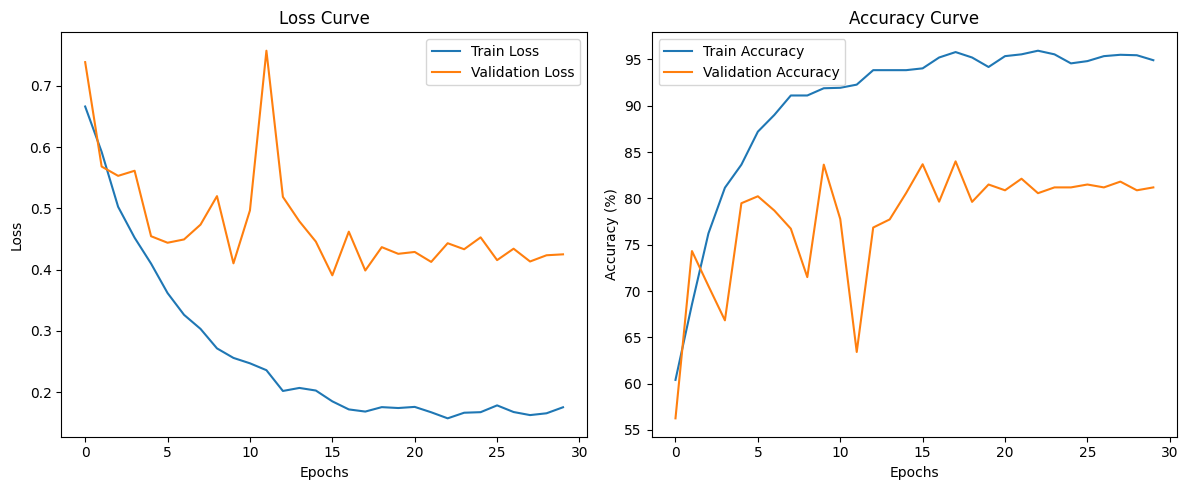

In [ ]:
plt.figure(figsize=(12, 5))

# loss graph
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy graph
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# show
plt.tight_layout()
plt.show()

# Evaluate

In [ ]:
model_path = '/content/drive/MyDrive/HW3_dataset/HW3_model.pth'
avg_test_loss, avg_test_acc, eva_p, eva_l = evaluate(model, device, model_path, test_loader)


Model weights loaded successfully.
Test Accuracy: 86.72%
Test Loss: 0.3199


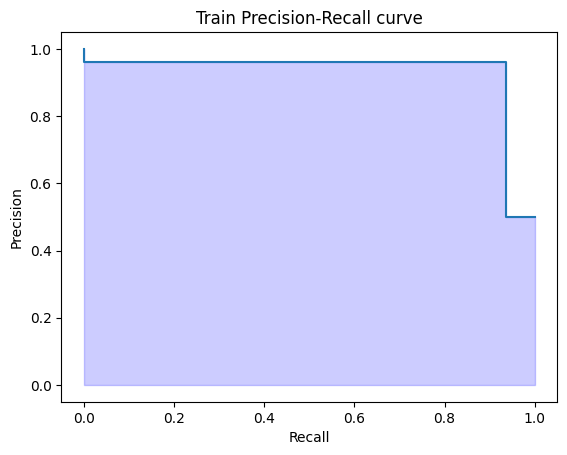

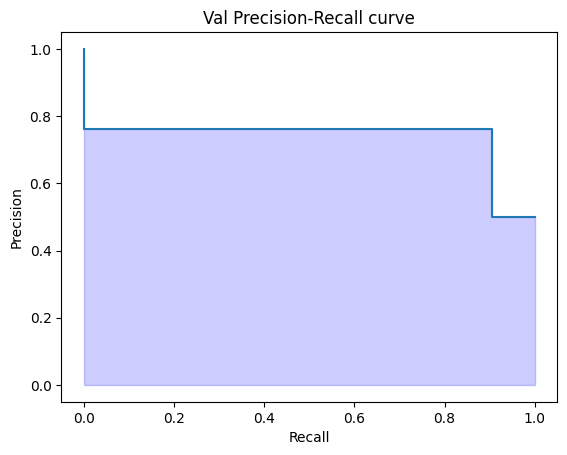

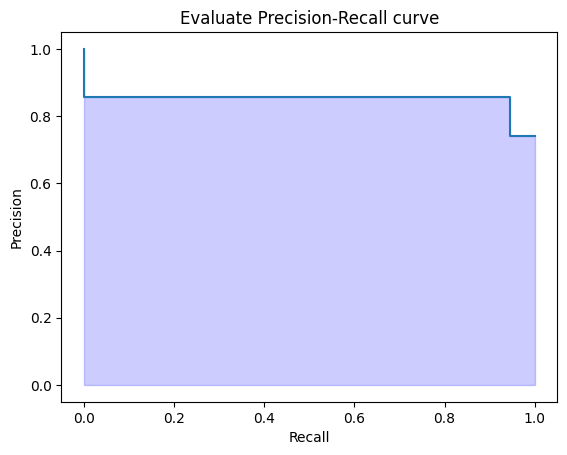

In [ ]:
# Plot precision-recall curve
pr_curve = torchmetrics.PrecisionRecallCurve(task='binary')

# Convert to tensors if they are lists
train_p = torch.tensor(train_p) if isinstance(train_p, list) else train_p
train_l = torch.tensor(train_l) if isinstance(train_l, list) else train_l
val_p = torch.tensor(val_p) if isinstance(val_p, list) else val_p
val_l = torch.tensor(val_l) if isinstance(val_l, list) else val_l
eva_p = torch.tensor(eva_p) if isinstance(eva_p, list) else eva_p
eva_l = torch.tensor(eva_l) if isinstance(eva_l, list) else eva_l

# Convert to float32
train_p = train_p.clone().detach() # Use clone and detach to create a copy of the tensor
train_l = train_l.clone().detach().long() # Use clone and detach to create a copy of the tensor and convert to long
val_p = val_p.clone().detach()  # Use clone().detach() to avoid unintended memory sharing
val_l = val_l.clone().detach().long() # Use clone and detach to create a copy of the tensor and convert to long
eva_p = eva_p.clone().detach()  # Use clone().detach() to avoid unintended memory sharing
eva_l = eva_l.clone().detach().long() # Use clone and detach to create a copy of the tensor and convert to long

precision_t, recall_t, thresholds_t = pr_curve(train_p, train_l)
plt.figure()
plt.step(recall_t, precision_t, where='post')
plt.fill_between(recall_t, precision_t, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Train Precision-Recall curve')
plt.show()

precision_v, recall_v, thresholds_v = pr_curve(val_p, val_l)
plt.figure()
plt.step(recall_v, precision_v, where='post')
plt.fill_between(recall_v, precision_v, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Val Precision-Recall curve')
plt.show()

precision_e, recall_e, thresholds_e = pr_curve(eva_p, eva_l)
plt.figure()
plt.step(recall_e, precision_e, where='post')
plt.fill_between(recall_e, precision_e, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Evaluate Precision-Recall curve')
plt.show()